In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
# train data
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12731041.48it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350724.53it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3207829.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2424965.47it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
# test data
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [12]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [13]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [15]:
train_data.targets.size()

torch.Size([60000])

In [17]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [18]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ac8510a6d40>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ac8510a71c0>}

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)

In [26]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']): .0}%)] \t {loss.item():.6}")

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.data.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /=len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n")

In [27]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-19-3d05f2e2349e>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0 / 60000 ( 0e+00%)] 	 2.30338
Train Epoch: 1 [2000 / 60000 ( 3e+00%)] 	 2.28977
Train Epoch: 1 [4000 / 60000 ( 7e+00%)] 	 2.16696
Train Epoch: 1 [6000 / 60000 ( 1e+01%)] 	 2.02476
Train Epoch: 1 [8000 / 60000 ( 1e+01%)] 	 2.01003
Train Epoch: 1 [10000 / 60000 ( 2e+01%)] 	 1.83396
Train Epoch: 1 [12000 / 60000 ( 2e+01%)] 	 1.80199
Train Epoch: 1 [14000 / 60000 ( 2e+01%)] 	 1.85815
Train Epoch: 1 [16000 / 60000 ( 3e+01%)] 	 1.70374
Train Epoch: 1 [18000 / 60000 ( 3e+01%)] 	 1.7511
Train Epoch: 1 [20000 / 60000 ( 3e+01%)] 	 1.77193
Train Epoch: 1 [22000 / 60000 ( 4e+01%)] 	 1.74146
Train Epoch: 1 [24000 / 60000 ( 4e+01%)] 	 1.65165
Train Epoch: 1 [26000 / 60000 ( 4e+01%)] 	 1.75845
Train Epoch: 1 [28000 / 60000 ( 5e+01%)] 	 1.72166
Train Epoch: 1 [30000 / 60000 ( 5e+01%)] 	 1.6871
Train Epoch: 1 [32000 / 60000 ( 5e+01%)] 	 1.66817
Train Epoch: 1 [34000 / 60000 ( 6e+01%)] 	 1.63712
Train Epoch: 1 [36000 / 60000 ( 6e+01%)] 	 1.62441
Train Epoch: 1 [38000 / 60000 ( 6e+01%)] 

In [28]:
device

device(type='cpu')

<ipython-input-19-3d05f2e2349e>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 1


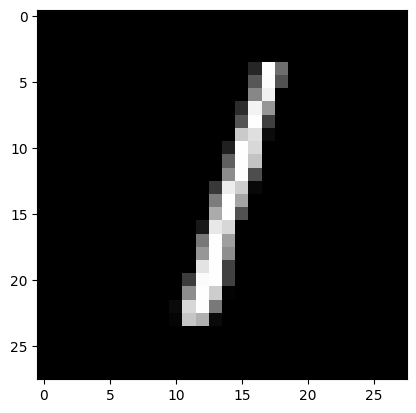

In [42]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[2]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()